# Начало

## Общие **


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from scipy import stats

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
from src.utils import *

## Исходные **

In [4]:
import os
import tqdm

In [5]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразовывает их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой нужно начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.notebook.tqdm(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)


def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)


   #здесь должен быть препроцессинг данных


   #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

## Мои **

In [6]:
def stat_test_2series(series_1, series_2, independent=True, p_value=0.05):
    s_total = pd.concat([series_1, series_2])
    
    if not independent:
        if series_1.shape[0] != series_2.shape[0]:
            independent = True
            
    shapiro = stats.shapiro(s_total)
    print('Результат теста Шапиро:')
    print(shapiro)
    if shapiro.pvalue > p_value:
        print('Распределение принято нормальным')
        if independent:
            leven = stats.levene(series_1, series_2)
            print('\t Результат теста Левена:')
            print('\t', leven)
            if leven.pvalue > p_value:
                print('\t Дисперсии выборок приняты равными')
                ttest = stats.ttest_ind(series_1, series_2)
                print('\t \t Т критерий Стюдента:')
                print('\t \t', ttest)      
                if ttest.pvalue > p_value:
                    print('\t \t Результат: распределения приняты равными')
                else:
                    print('\t \t Результат: распределения приняты НЕ равными')
            else:
                print('\t Дисперсии выборок НЕ приняты равными')
                uelch = stats.ttest_ind(series_1, series_2, equal_var=False)
                print('\t \t Критерий Уэлча:')
                print('\t \t', uelch)      
                if uelch.pvalue > p_value:
                    print('\t \t Результат: распределения приняты равными')
                else:
                    print('\t \t Результат: распределения приняты НЕ равными')
        else:
            tt_rel = stats.ttest_rel(series_1, series_2)
            print('\t Результат парного Т-теста:')
            print('\t', tt_rel)
            if tt_rel.pvalue > p_value:
                print('\t Результат: распределения приняты равными')
            else:
                print('\t Результат: распределения приняты НЕ равными')
    else:
        print('Распределение не принято нормальным')
        if independent:
            mann_wh = stats.mannwhitneyu(series_1, series_2)
            print('\t Результат теста Манна-Уитни:')
            print('\t', mann_wh)
            if mann_wh.pvalue > p_value:
                print('\t Результат: распределения приняты равными')
            else:
                print('\t Результат: распределения приняты НЕ равными')
        else:
            wilcxn = stats.wilcoxon(series_1, series_2)
            print('\t Результат теста Вилкоксона:')
            print('\t', wilcxn)
            if wilcxn.pvalue > p_value:
                print('\t Результат: распределения приняты равными')
            else:
                print('\t Результат: распределения приняты НЕ равными')
        

In [11]:
# пока этот вариант проверим
def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
        #здесь должен быть препроцессинг данных
        columns = list(transactions_frame.columns)
        columns.remove('id')

        for column in columns:
            transactions_frame[column] = transactions_frame[column].astype(np.int8)

        #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [12]:
# пока этот вариант проверим
def prepare_by_column(path_to_dataset: str, selected_column:str, target_path: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
                                 save_to_path=None, verbose: bool=False):
    """
    возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
    path_to_dataset: str
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int
        количество партиций, которые будут одновременно держаться и обрабатываться в памяти
    num_parts_total: int
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
    verbose: bool
        логирует каждую обрабатываемую часть данных
    """
    preprocessed_frames = []

    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
                                                             verbose=verbose)
        #здесь должен быть препроцессинг данных
        columns = list(transactions_frame.columns)
        
        if selected_column in columns:
            transactions_frame[selected_column] = transactions_frame[selected_column].astype(np.int8)
        else:
            print('no selected column')
            return

        #записываем подготовленные данные в файл
        if save_to_path:
            block_as_str = str(step)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
        
        targets = pd.read_csv(target_path)
        transactions_frame = pd.merge(left=transactions_frame[['id', selected_column]], right=targets, on='id')
        preprocessed_frames.append(transactions_frame)
    return pd.concat(preprocessed_frames)

In [9]:
# def prepare_transactions_dataset(path_to_dataset: str, num_parts_to_preprocess_at_once: int = 1, num_parts_total: int=50,
#                                  save_to_path=None, verbose: bool=False):
#     """
#     возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи
#     path_to_dataset: str
#         путь до датасета с партициями
#     num_parts_to_preprocess_at_once: int
#         количество партиций, которые будут одновременно держаться и обрабатываться в памяти
#     num_parts_total: int
#         общее количество партиций, которые нужно обработать
#     save_to_path: str
#         путь до папки, в которой будет сохранён каждый обработанный блок в .parquet-формате; если None, то не будет сохранён
#     verbose: bool
#         логирует каждую обрабатываемую часть данных
#     """
#     preprocessed_frames = []

#     for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
#                                    desc="Transforming transactions data"):
#         transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once,
#                                                              verbose=verbose)
#         #здесь должен быть препроцессинг данных
#         columns = list(transactions_frame.columns)
#         # print(columns)
#         columns.remove('id')

#         for column in columns:
#             transactions_frame[column] = transactions_frame[column].astype(np.int8)
        
#         df = transactions_frame
#         print(df.columns)
        
#         for column in columns:
#             ser1 = df[df.flag==0][column]
#             ser2 = df[df.flag==1][column]
#             stat_test_2series(ser1, ser2)
#             sns.histplot(ser1, discrete=True)
#             sns.histplot(ser2, discrete=True)

#         #записываем подготовленные данные в файл
#         if save_to_path:
#             block_as_str = str(step)
#             if len(block_as_str) == 1:
#                 block_as_str = '00' + block_as_str
#             else:
#                 block_as_str = '0' + block_as_str
#             transactions_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))

#         preprocessed_frames.append(transactions_frame)
    
#     return pd.concat(preprocessed_frames)

In [10]:
df_rn = prepare_by_column('train_data', 'rn', 'train_target.csv', num_parts_total=12)
df_rn

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25232\1735174351.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_0.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_1.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_10.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_11.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_2.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_3.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_4.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_5.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_6.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_7.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_8.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_9.pq


,id,rn,flag
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,0
...,...,...,...
2284251,2499999,11,0
2284252,2499999,12,0
2284253,2499999,13,0
2284254,2499999,14,0


In [11]:
df_t = df_rn.drop(columns='id')

In [12]:
df_t.flag = df_t.flag.astype('int8')

In [14]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26162717 entries, 0 to 2284255
Data columns (total 2 columns):
 #   Column  Dtype
---  ------  -----
 0   rn      int8 
 1   flag    int8 
dtypes: int8(2)
memory usage: 249.5 MB


<Axes: xlabel='rn', ylabel='Count'>

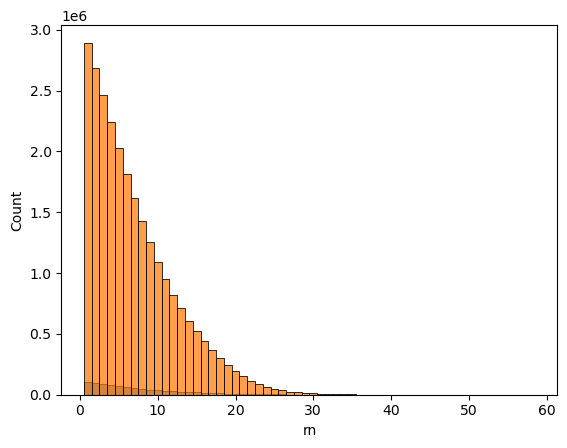

In [13]:
sns.histplot(df_t[df_t.flag==1].rn, discrete=True)
sns.histplot(df_t[df_t.flag==0].rn, discrete=True)

In [15]:
stat_test_2series(df_t[df_t.flag==1].rn, df_t[df_t.flag==0].rn)

D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9514995217323303, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11142165286266.5, pvalue=0.0039010966600797727)
	 Результат: распределения приняты НЕ равными


In [15]:
df = prepare_by_column('train_data', 'pre_since_opened', 'train_target.csv', num_parts_total=12)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10384\1735174351.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_0.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_1.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_10.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_11.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_2.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_3.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_4.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_5.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_6.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_7.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_8.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_9.pq


In [16]:
stat_test_2series(df[df.flag==1].pre_since_opened, df[df.flag==0].pre_since_opened)

D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=1.00737726688385, pvalue=1.0)
Распределение принято нормальным
	 Результат теста Левена:
	 LeveneResult(statistic=0.7365396798791466, pvalue=0.3907716097712929)
	 Дисперсии выборок приняты равными
	 	 Т критерий Стюдента:
	 	 TtestResult(statistic=14.225113169388882, pvalue=6.4026025462665026e-46, df=26162715.0)
	 	 Результат: распределения приняты НЕ равными


<Axes: xlabel='pre_since_opened', ylabel='Count'>

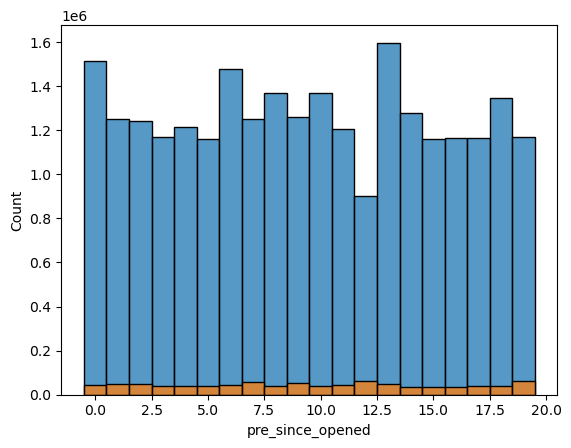

In [17]:
sns.histplot(df[df.flag==0].pre_since_opened, discrete=True)
sns.histplot(df[df.flag==1].pre_since_opened, discrete=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10384\1735174351.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_0.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_1.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_10.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_11.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_2.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_3.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_4.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_5.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_6.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_7.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_8.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_9.pq


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9287996888160706, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11280520208482.5, pvalue=1.4733387073314447e-114)
	 Результат: распределения приняты НЕ равными


<Axes: xlabel='pre_since_confirmed', ylabel='Count'>

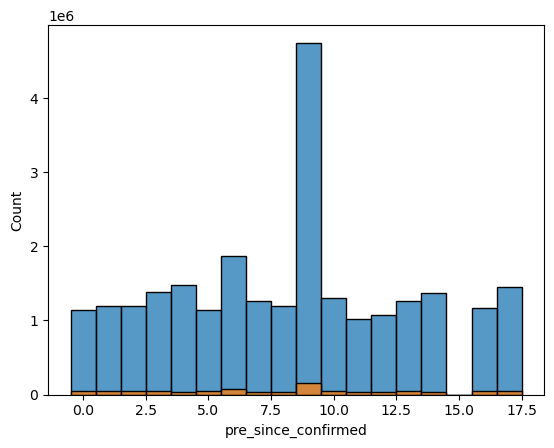

In [18]:
column = 'pre_since_confirmed'
df = prepare_by_column('train_data', column, 'train_target.csv', num_parts_total=12)

ser1 = df[df.flag==0][column]
ser2 = df[df.flag==1][column]
stat_test_2series(ser1, ser2)
sns.histplot(ser1, discrete=True)
sns.histplot(ser2, discrete=True)

In [13]:
data = prepare_transactions_dataset('train_data', num_parts_total=12)
targets = pd.read_csv('train_target.csv')
data = pd.merge(left=data, right=targets, on='id')



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18628\2111866635.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once),


Transforming transactions data:   0%|          | 0/12 [00:00<?, ?it/s]

['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_0.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_1.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_10.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_11.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_2.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_3.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_4.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_5.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_6.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_7.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_8.pq
['train_data\\train_data_0.pq', 'train_data\\train_data_1.pq', 'train_data\\train_data_10.pq', 'train_data\\train_data_11.pq', 'train_data\\train_data_2.pq', 'train_data\\train_data_3.pq', 'train_data\\train_data_4.pq', 'train_data\\train_data_5.pq', 'train_data\\train_data_6.pq', 'train_data\\train_data_7.pq', 'train_data\\train_data_8.pq', 'train_data\\train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data\train_data_9.pq


In [ ]:
data.columns

In [17]:
columns = ['pre_since_confirmed', 'pre_pterm', 'pre_since_opened',  #'rn', 
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24',
       'enc_loans_account_holder_type', 'enc_loans_credit_status',
       'enc_loans_credit_type', 'enc_loans_account_cur', 'pclose_flag',
       'fclose_flag']

pre_since_confirmed


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9287996888160706, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11280520208482.5, pvalue=1.4733387073314447e-114)
	 Результат: распределения приняты НЕ равными


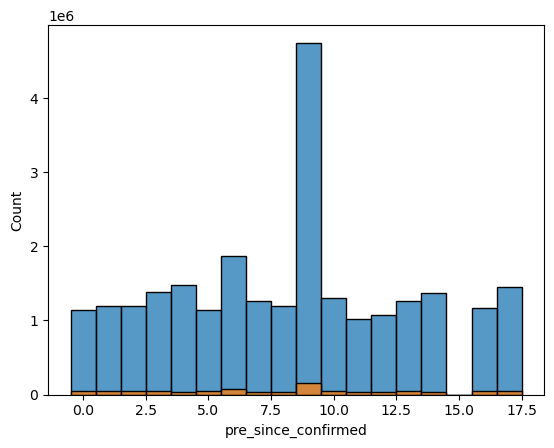

pre_pterm


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8604592084884644, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11400138525323.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


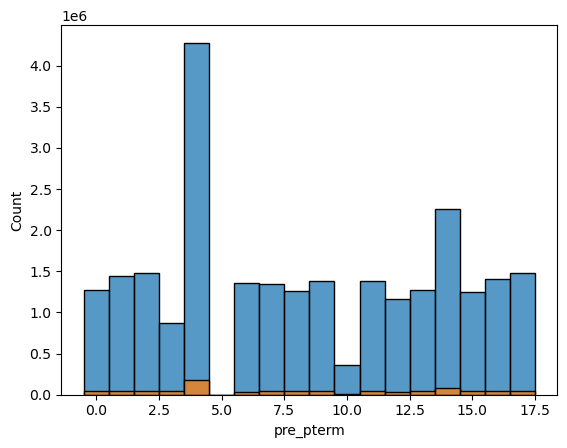

pre_fterm


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9769007563591003, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11427357502606.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


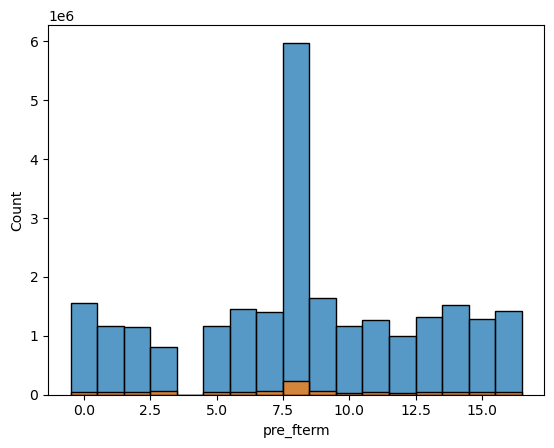

pre_till_pclose


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.981977641582489, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11044309136991.0, pvalue=6.218358654495551e-29)
	 Результат: распределения приняты НЕ равными


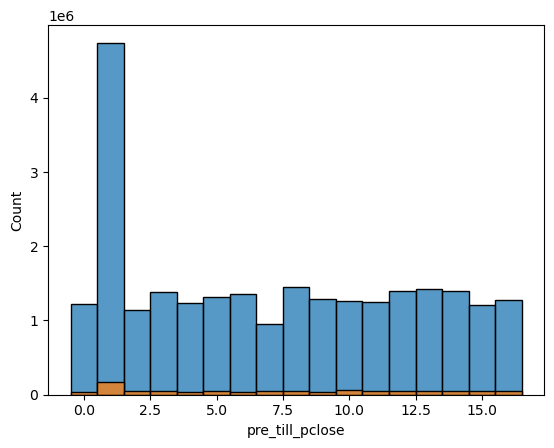

pre_till_fclose


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9348923563957214, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10955066030231.0, pvalue=4.372734827581656e-127)
	 Результат: распределения приняты НЕ равными


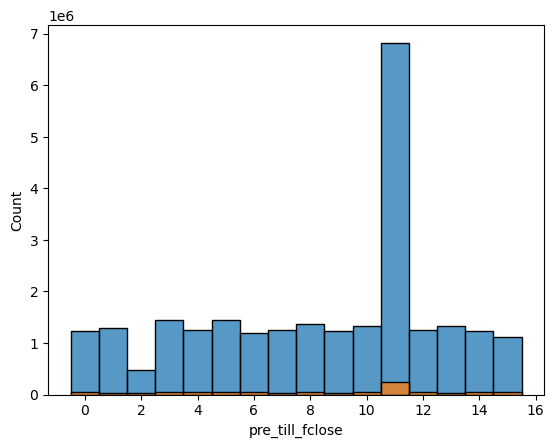

pre_loans_credit_limit


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9211938381195068, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10774843026997.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


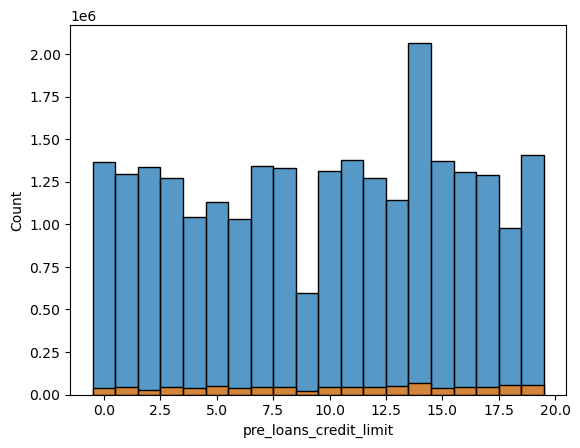

pre_loans_next_pay_summ


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8018403053283691, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11149022967778.0, pvalue=0.00010797314825894357)
	 Результат: распределения приняты НЕ равными


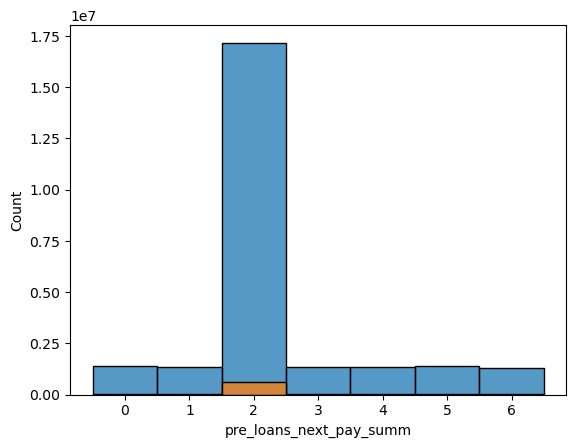

pre_loans_outstanding


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.6462147235870361, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10958752636606.5, pvalue=1.2683929980249923e-121)
	 Результат: распределения приняты НЕ равными


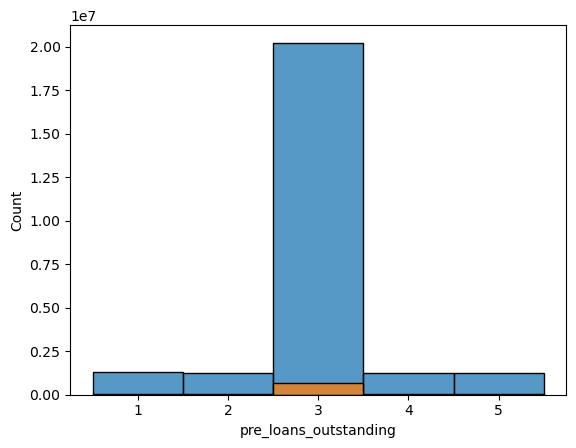

pre_loans_total_overdue


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=1.3709068298339844e-06, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11122052360832.0, pvalue=0.9985517848734689)
	 Результат: распределения приняты равными


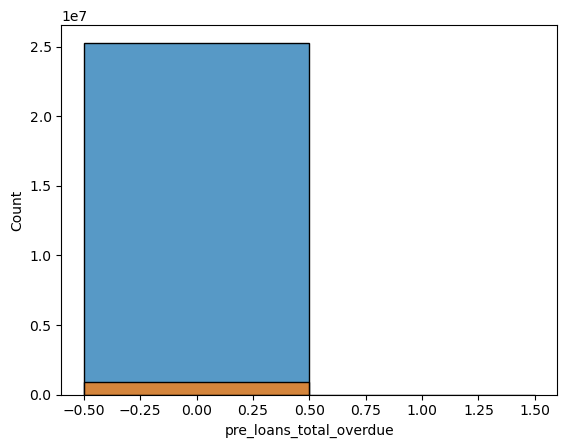

pre_loans_max_overdue_sum


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.4010138511657715, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11229968365007.0, pvalue=3.6757760966279233e-54)
	 Результат: распределения приняты НЕ равными


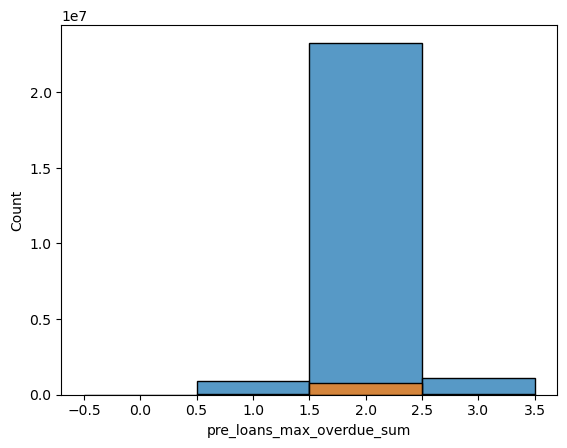

pre_loans_credit_cost_rate


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9184669256210327, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11035939819984.0, pvalue=3.852676833062063e-35)
	 Результат: распределения приняты НЕ равными


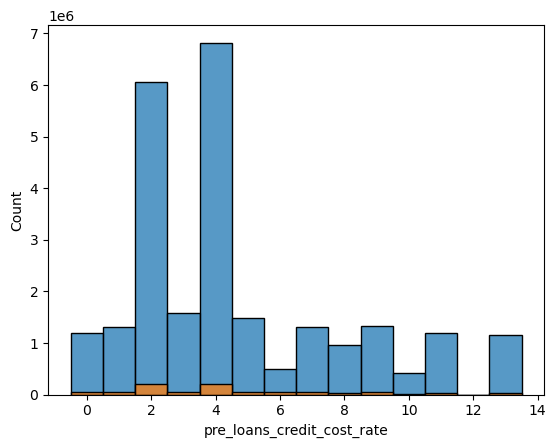

pre_loans5


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.04589051008224487, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11164378107827.0, pvalue=1.233980057046614e-09)
	 Результат: распределения приняты НЕ равными


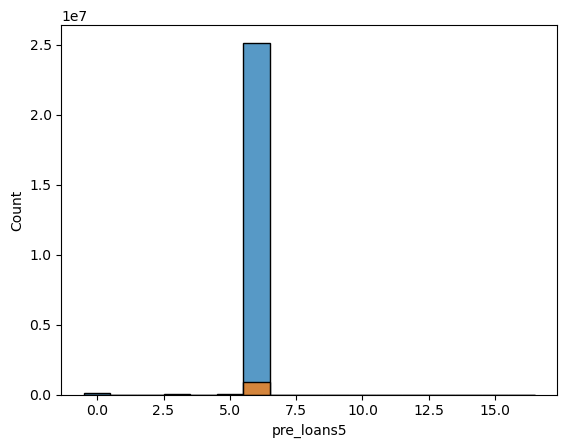

pre_loans530


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.09572333097457886, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11208260803424.5, pvalue=3.3887926645215895e-35)
	 Результат: распределения приняты НЕ равными


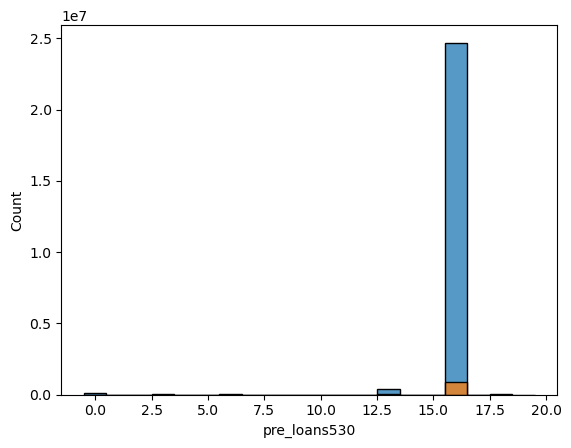

pre_loans3060


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.008358418941497803, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11114502713037.0, pvalue=0.2775040907846055)
	 Результат: распределения приняты равными


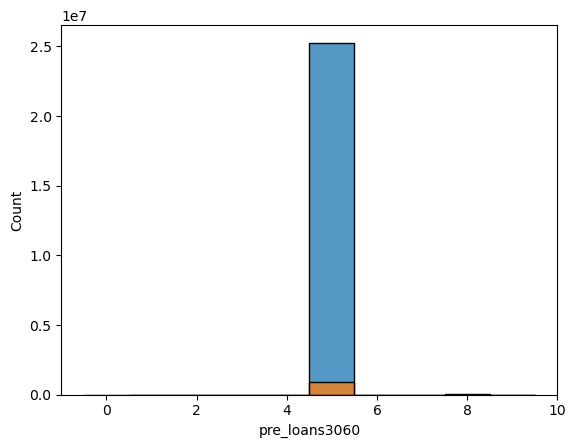

pre_loans6090


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.0009156465530395508, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11123300436485.5, pvalue=0.8592168906550554)
	 Результат: распределения приняты равными


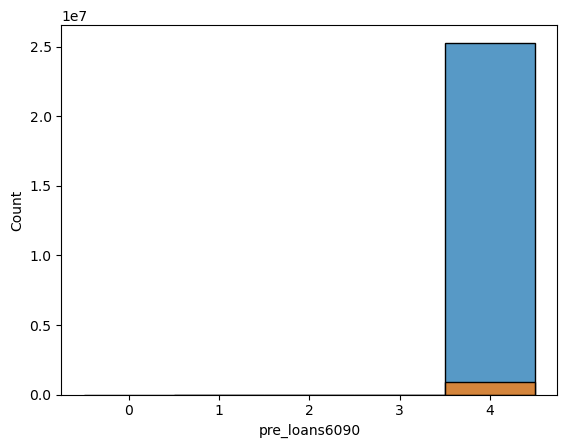

pre_loans90


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.007529616355895996, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11112672031481.5, pvalue=0.1773740219500024)
	 Результат: распределения приняты равными


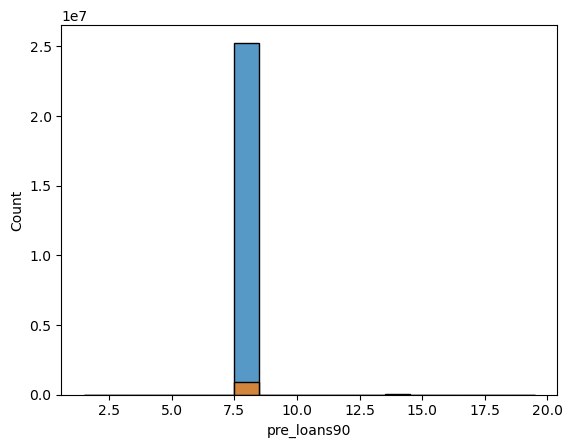

is_zero_loans5


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.33245599269866943, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11352144414327.5, pvalue=1.942037727211967e-239)
	 Результат: распределения приняты НЕ равными


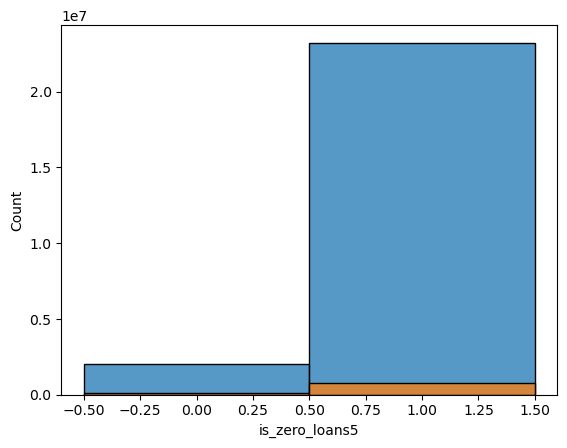

is_zero_loans530


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.449069082736969, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11716098625140.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


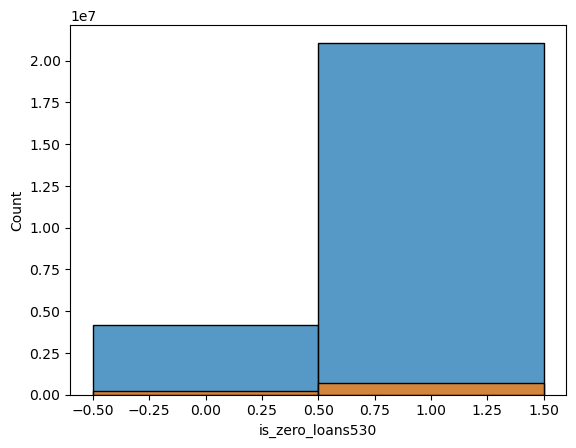

is_zero_loans3060


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.23305892944335938, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11507259826121.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


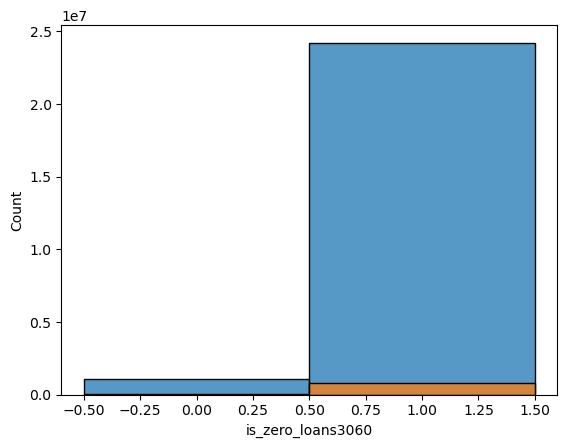

is_zero_loans6090


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.14751732349395752, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11399484443203.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


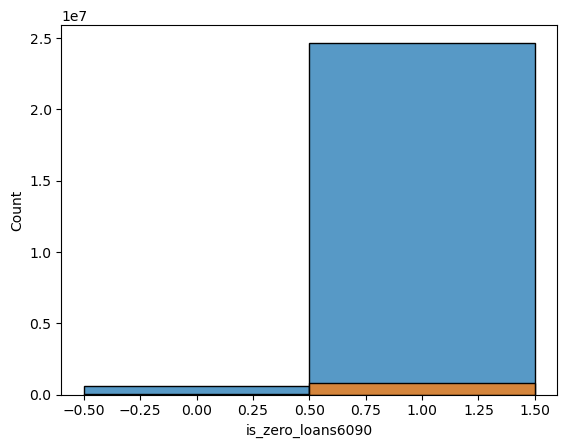

is_zero_loans90


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.14492416381835938, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11408576225151.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


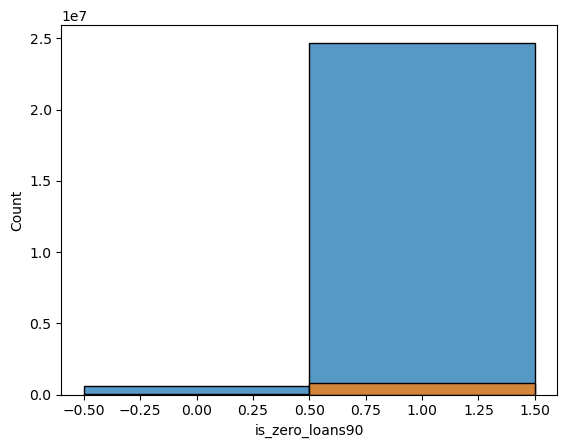

pre_util


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.6660059690475464, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11444152907635.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


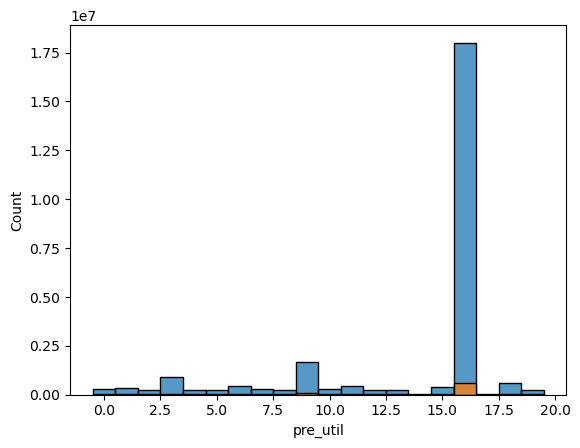

pre_over2limit


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.2579500675201416, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11089307570563.5, pvalue=2.550215937495297e-06)
	 Результат: распределения приняты НЕ равными


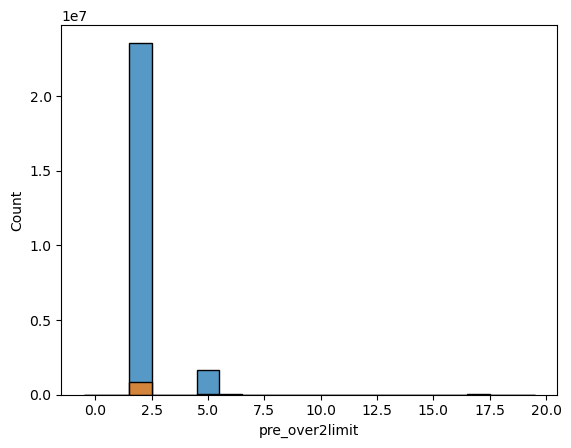

pre_maxover2limit


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.3709718585014343, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11343407864634.0, pvalue=9.153646814651534e-222)
	 Результат: распределения приняты НЕ равными


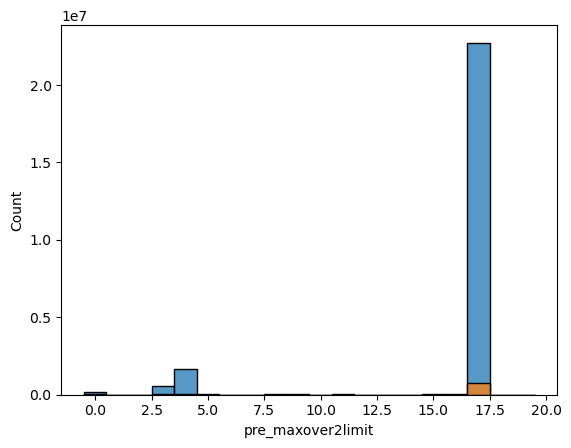

is_zero_util


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8819193243980408, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11539499843924.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


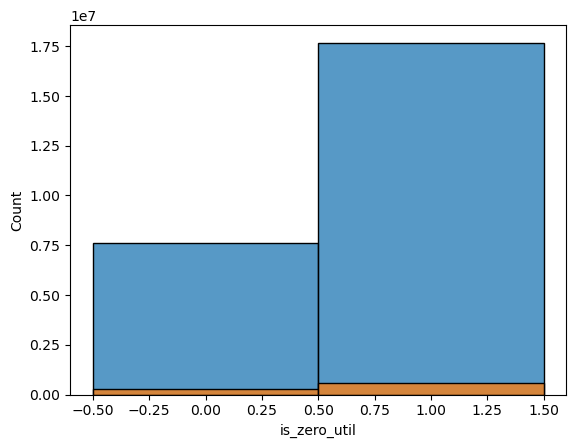

is_zero_over2limit


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.3000938296318054, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11194752525005.0, pvalue=1.6236053663308104e-25)
	 Результат: распределения приняты НЕ равными


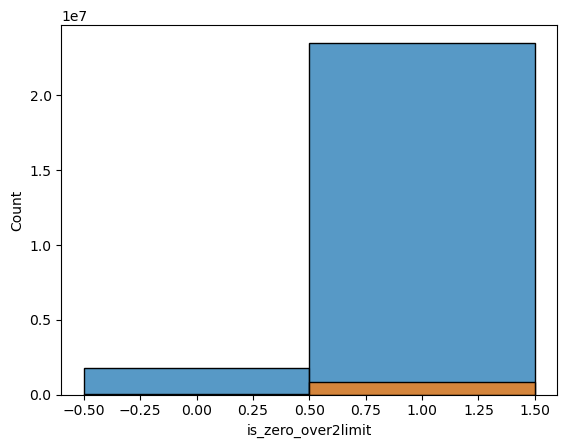

is_zero_maxover2limit


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.42233020067214966, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11432973592033.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


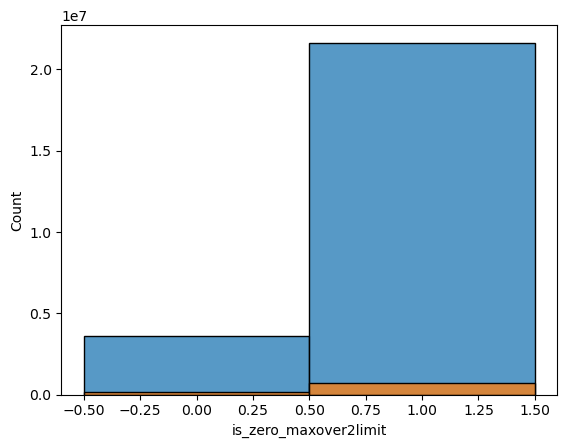

enc_paym_0


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.2969215512275696, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10593177064791.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


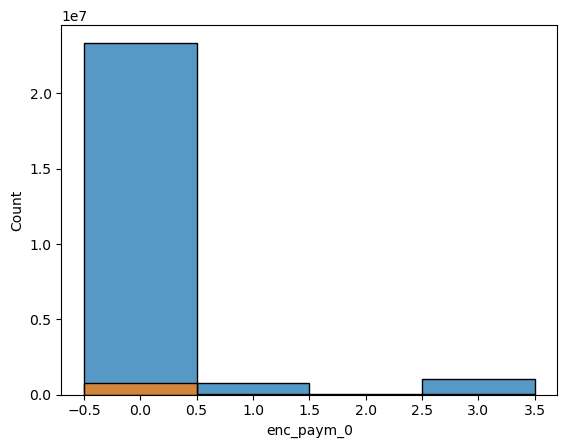

enc_paym_1


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.4648166298866272, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10143518411125.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


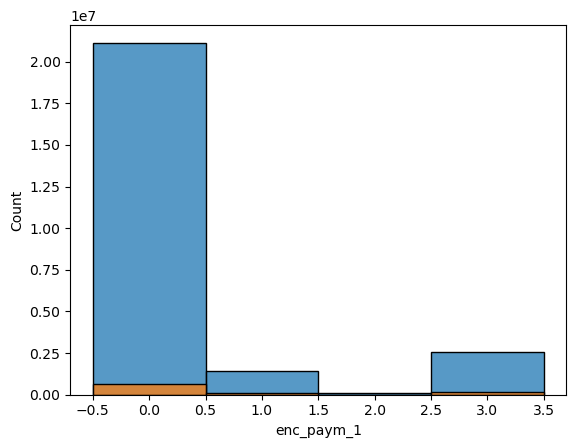

enc_paym_2


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.5652320384979248, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10005635910392.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


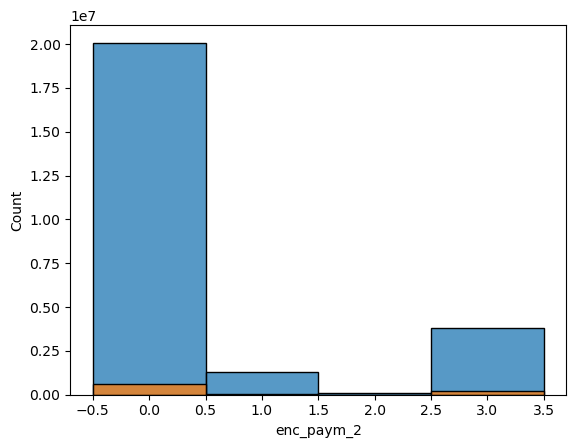

enc_paym_3


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.6221024990081787, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10007559891066.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


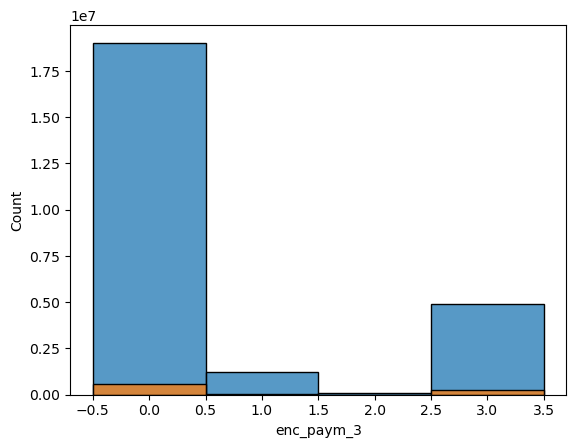

enc_paym_4


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.6335220336914062, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10049531738324.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


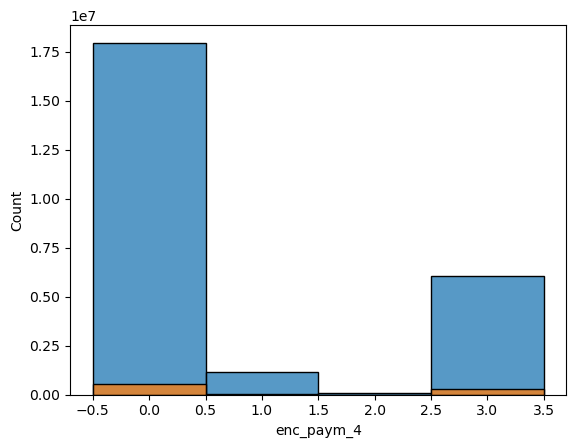

enc_paym_5


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.6485365033149719, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10100699717445.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


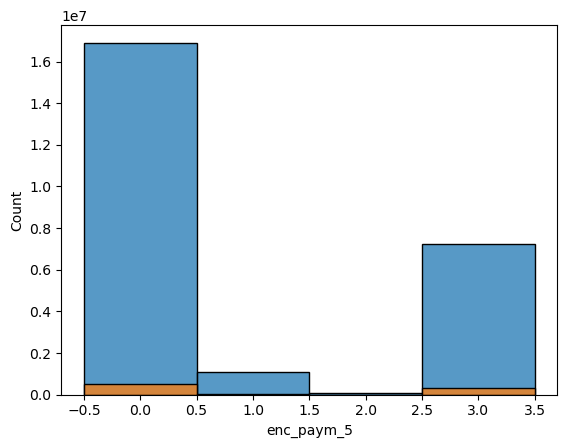

enc_paym_6


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.5919315814971924, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10173008893386.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


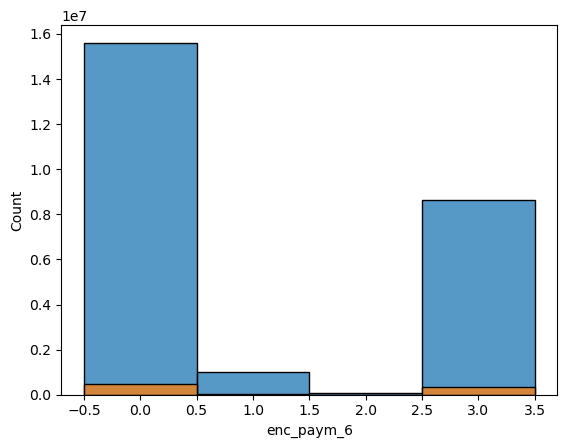

enc_paym_7


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.846108615398407, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10222664086443.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


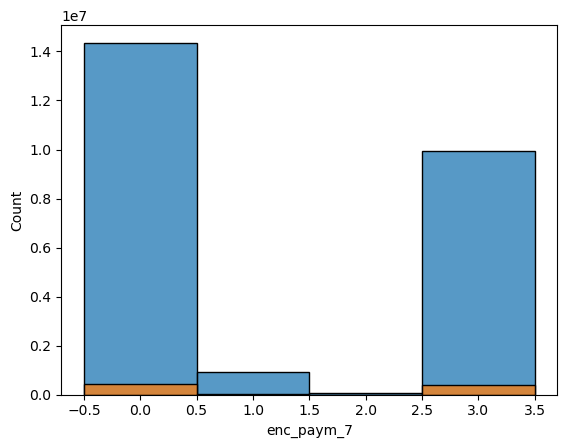

enc_paym_8


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.5838755369186401, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10264562264054.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


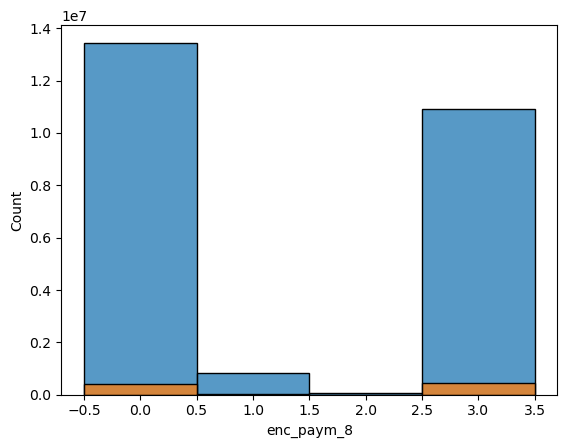

enc_paym_9
Результат теста Шапиро:
ShapiroResult(statistic=0.9516597390174866, pvalue=0.0)
Распределение не принято нормальным


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10301129322449.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


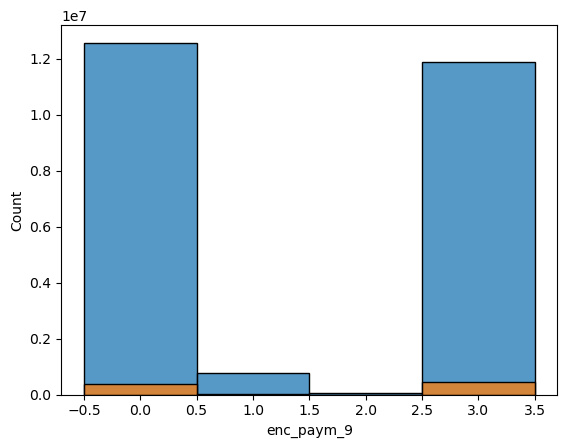

enc_paym_10


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9333619475364685, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10365470220289.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


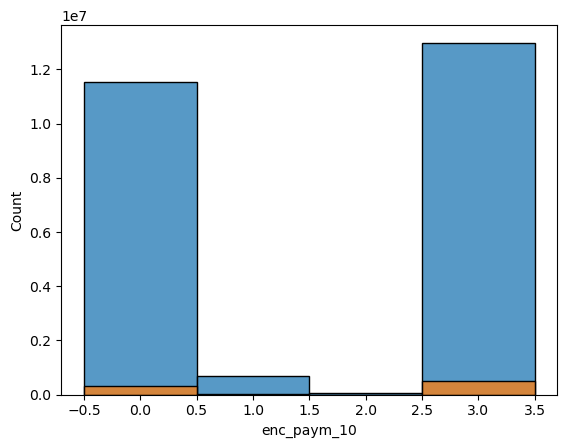

enc_paym_11


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8400076627731323, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10414213281850.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


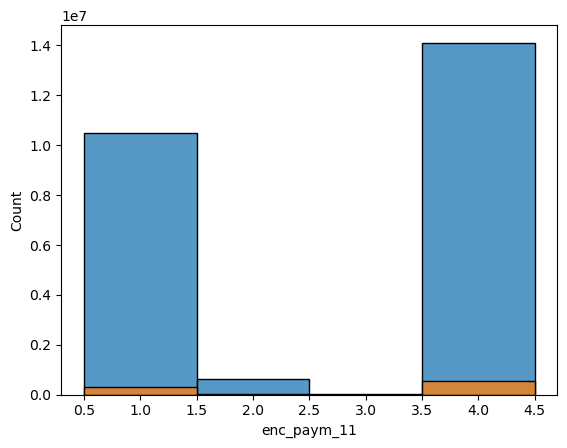

enc_paym_12


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9073989987373352, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10462019530585.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


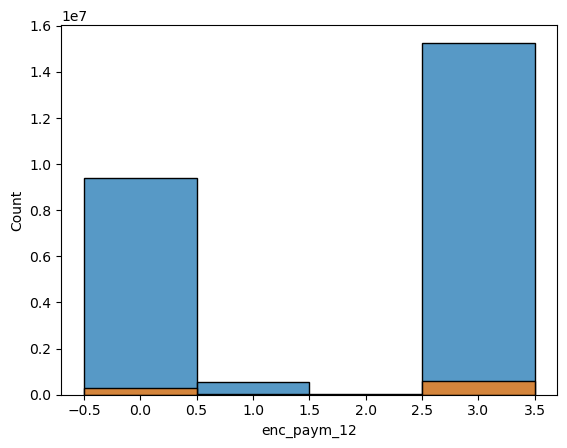

enc_paym_13


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=1.0430095195770264, pvalue=1.0)
Распределение принято нормальным
	 Результат теста Левена:
	 LeveneResult(statistic=12170.062259464508, pvalue=0.0)
	 Дисперсии выборок НЕ приняты равными
	 	 Критерий Уэлча:
	 	 TtestResult(statistic=-115.91845531879055, pvalue=0.0, df=949168.4521096341)
	 	 Результат: распределения приняты НЕ равными


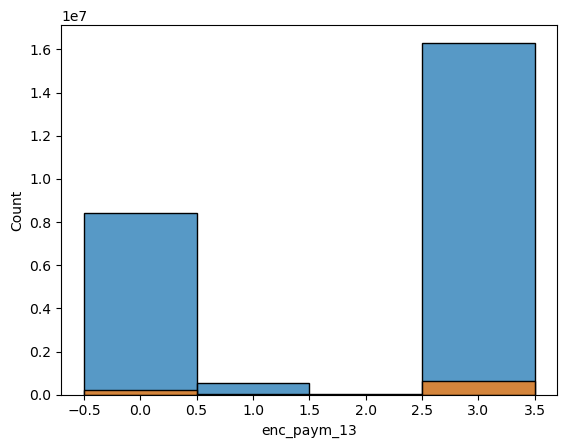

enc_paym_14


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.9326484799385071, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10500623934402.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


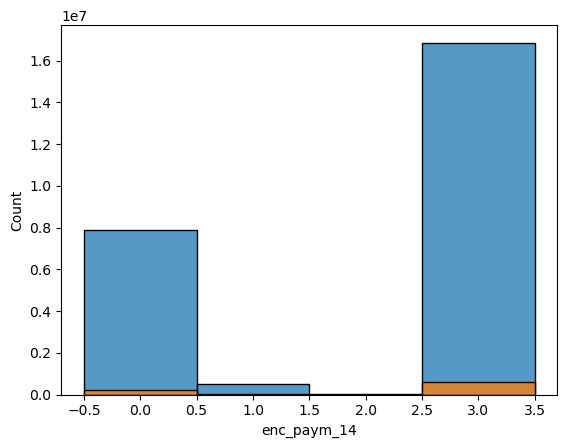

enc_paym_15


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8598467111587524, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10514965009567.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


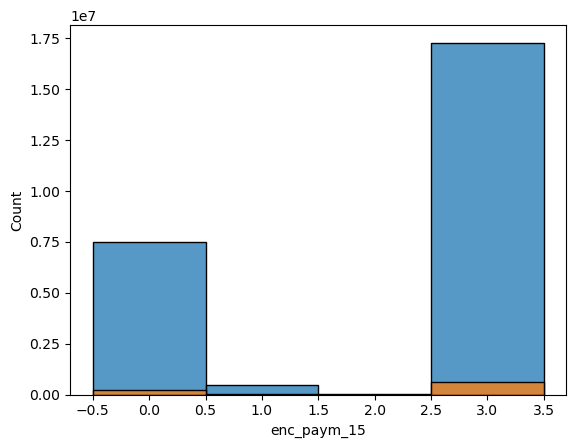

enc_paym_16


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8316211700439453, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10530594447771.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


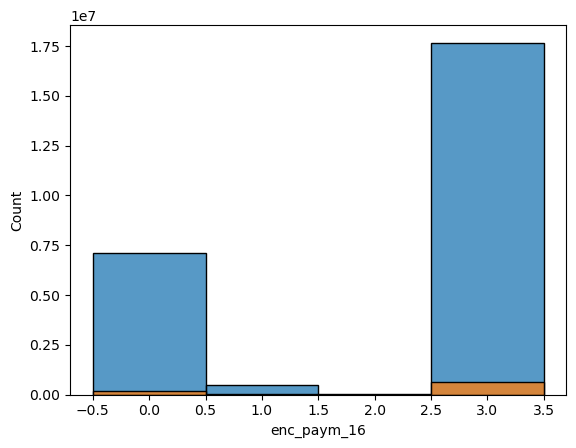

enc_paym_17


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8039437532424927, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10550832859964.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


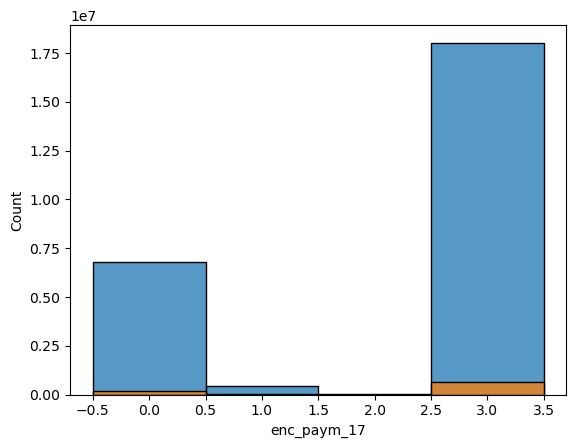

enc_paym_18


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.7733659744262695, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10571652109052.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


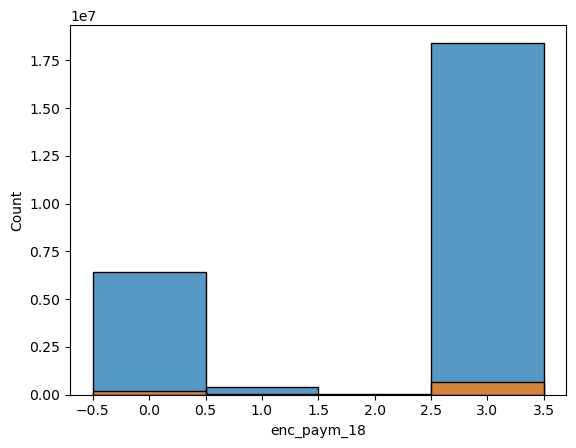

enc_paym_19


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.7085515856742859, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10590791637979.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


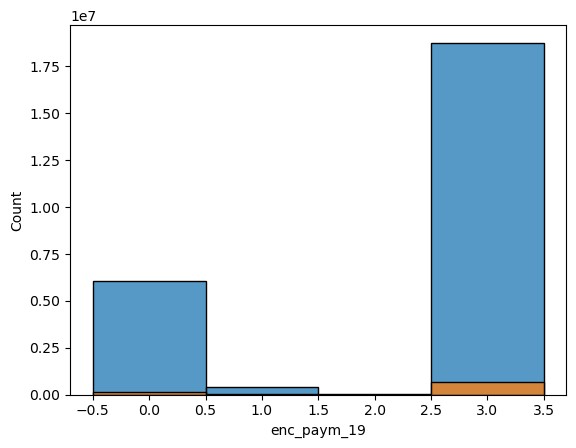

enc_paym_20


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.7255579233169556, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10613513484669.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


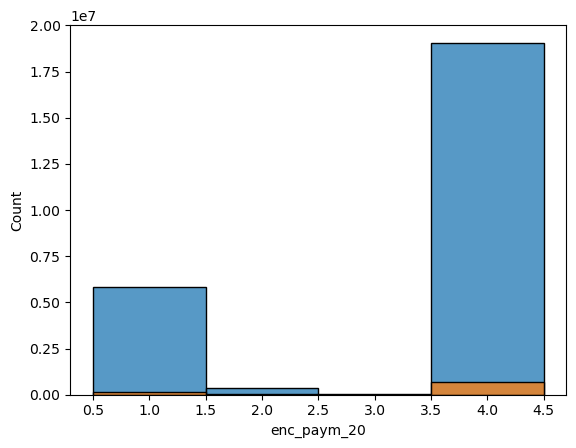

enc_paym_21


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.7058819532394409, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10633738765264.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


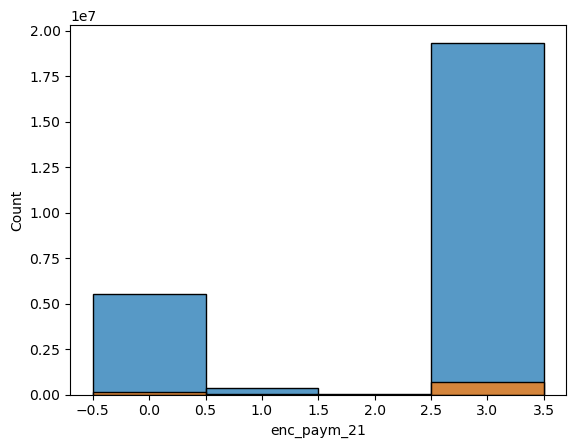

enc_paym_22


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.6779364347457886, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10656826777714.5, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


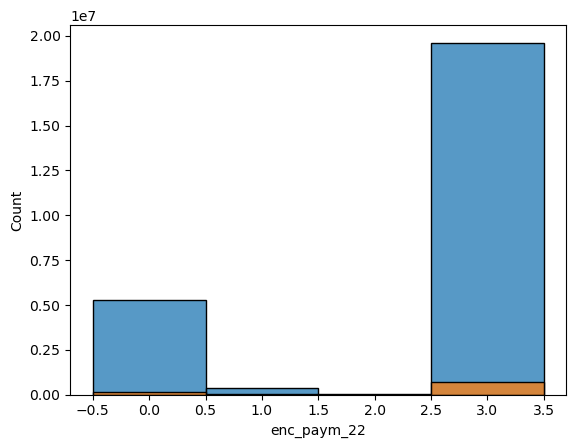

enc_paym_23


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.5657808780670166, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10680156743948.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


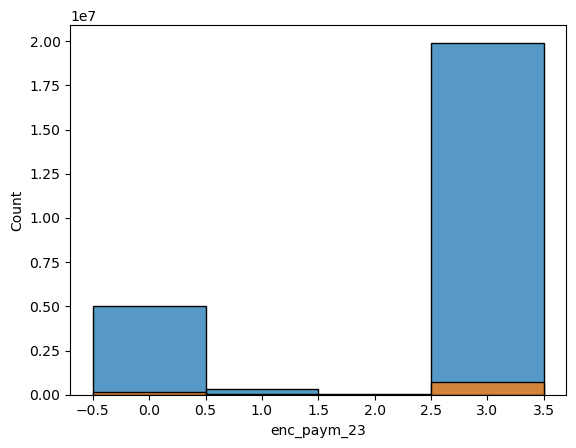

enc_paym_24


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.45277100801467896, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10823454881098.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


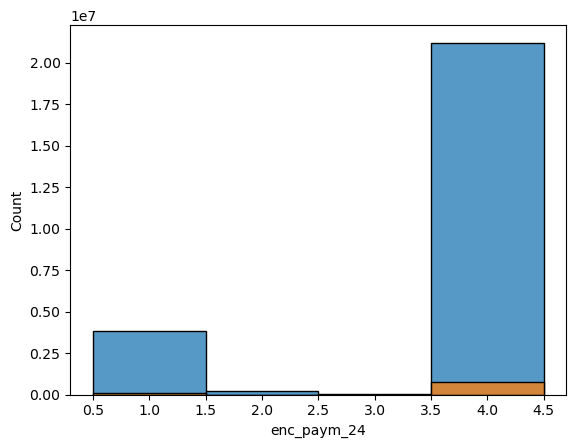

enc_loans_account_holder_type


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.09385615587234497, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11180335373282.5, pvalue=5.940998592057863e-17)
	 Результат: распределения приняты НЕ равными


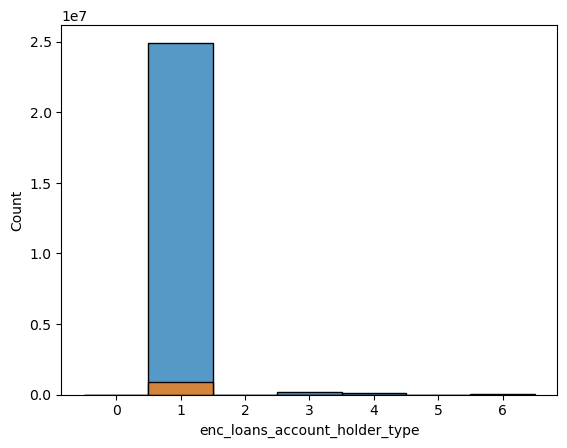

enc_loans_credit_status


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.7657581567764282, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11326798670708.0, pvalue=4.853755810558678e-190)
	 Результат: распределения приняты НЕ равными


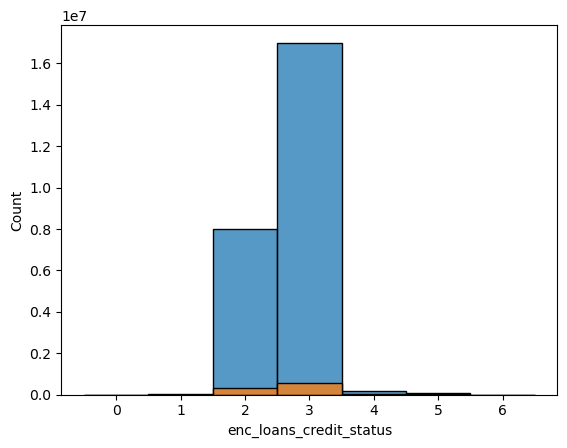

enc_loans_credit_type


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.8231722116470337, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10367284375699.0, pvalue=0.0)
	 Результат: распределения приняты НЕ равными


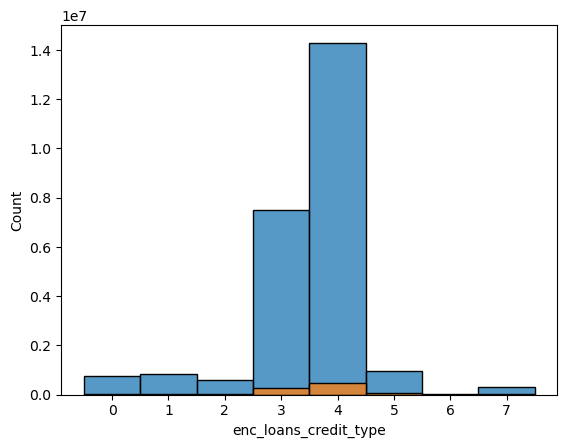

enc_loans_account_cur


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.02652108669281006, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11130978678490.0, pvalue=0.2005732542073031)
	 Результат: распределения приняты равными


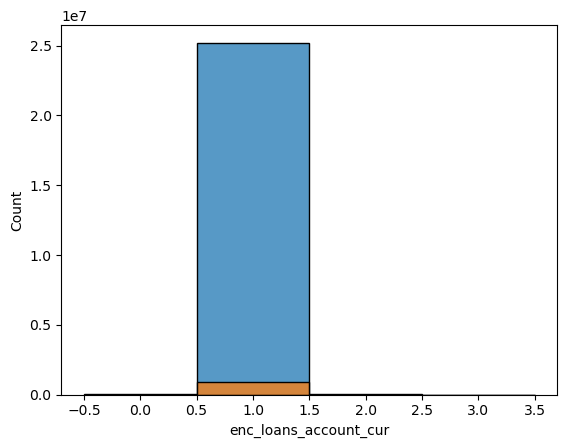

pclose_flag


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.4329453110694885, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=11102294807835.0, pvalue=0.004524546442124619)
	 Результат: распределения приняты НЕ равными


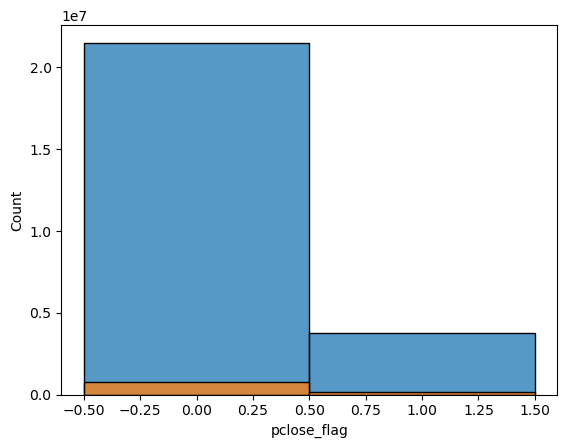

fclose_flag


D:\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Результат теста Шапиро:
ShapiroResult(statistic=0.5913349390029907, pvalue=0.0)
Распределение не принято нормальным
	 Результат теста Манна-Уитни:
	 MannwhitneyuResult(statistic=10927664340922.0, pvalue=2.0225137740730011e-171)
	 Результат: распределения приняты НЕ равными


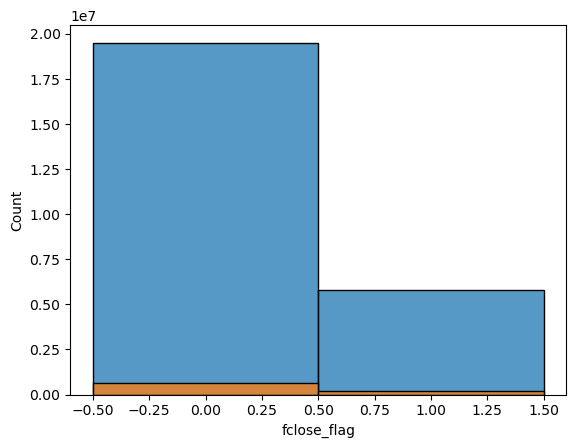

In [30]:


for column in columns:
    print(column)
    ser1 = data[data.flag==0][column]
    ser2 = data[data.flag==1][column]
    stat_test_2series(ser1, ser2)
    sns.histplot(ser1, discrete=True)
    sns.histplot(ser2, discrete=True)
    plt.show()

In [14]:
data.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [15]:
s0 = data[data.flag==0]['pre_since_opened'].value_counts()
s1 = data[data.flag==1]['pre_since_opened'].value_counts()
st = data['pre_since_opened'].value_counts()

vc_df = pd.DataFrame({'flag_0': s0/st, 'flag_1': s1/st, 'total': st})

print(vc_df)

                    flag_0    flag_1    total
pre_since_opened                             
0                 0.971227  0.028773  1561873
1                 0.962037  0.037963  1300842
2                 0.963813  0.036187  1290724
3                 0.966676  0.033324  1211933
4                 0.969602  0.030398  1255220
5                 0.968508  0.031492  1196677
6                 0.970969  0.029031  1522882
7                 0.956828  0.043172  1307521
8                 0.973672  0.026328  1406244
9                 0.960066  0.039934  1312790
10                0.972034  0.027966  1409770
11                0.965310  0.034690  1250266
12                0.937962  0.062038   959874
13                0.971435  0.028565  1645938
14                0.972136  0.027864  1315095
15                0.972714  0.027286  1193193
16                0.971291  0.028709  1200566
17                0.967851  0.032149  1202495
18                0.970414  0.029586  1388400
19                0.951502  0.0484

In [18]:
for column in columns:
    s0 = data[data.flag==0][column].value_counts()
    s1 = data[data.flag==1][column].value_counts()
    st = data[column].value_counts()

    vc_df = pd.DataFrame({'flag_0': s0/st, 'flag_1': s1/st, 'total': st})

    print(vc_df)
    print()

                       flag_0    flag_1    total
pre_since_confirmed                             
0                    0.962411  0.037589  1192383
1                    0.961912  0.038088  1245131
2                    0.962721  0.037279  1239514
3                    0.965486  0.034514  1435553
4                    0.972860  0.027140  1514861
5                    0.961337  0.038663  1180787
6                    0.963334  0.036666  1948337
7                    0.973894  0.026106  1291490
8                    0.969206  0.030794  1234641
9                    0.967627  0.032373  4909419
10                   0.960949  0.039051  1361991
11                   0.969145  0.030855  1058230
12                   0.968417  0.031583  1108831
13                   0.963685  0.036315  1313856
14                   0.971336  0.028664  1410504
15                   0.978723  0.021277      188
16                   0.962256  0.037744  1213550
17                   0.967990  0.032010  1503451

             flag_0

In [36]:
data['pre_loans_total_overdue'].value_counts()

pre_loans_total_overdue
0    26162716
1           1
Name: count, dtype: int64

In [42]:
data['pre_loans3060'].value_counts()

pre_loans3060
5    26147054
8       12924
2        2115
7         468
9         112
1          34
6           6
0           2
3           1
4           1
Name: count, dtype: int64

In [43]:
data[data['flag']==1]['pre_loans3060'].value_counts()

pre_loans3060
5    878411
8      1127
2       215
7        44
9         8
1         4
Name: count, dtype: int64

In [44]:
data[data['flag']==0]['pre_loans3060'].value_counts()

pre_loans3060
5    25268643
8       11797
2        1900
7         424
9         104
1          30
6           6
0           2
3           1
4           1
Name: count, dtype: int64

In [45]:
data[data['flag']==0]['pre_loans3060'].value_counts()/28.7

pre_loans3060
5    880440.522648
8       411.045296
2        66.202091
7        14.773519
9         3.623693
1         1.045296
6         0.209059
0         0.069686
3         0.034843
4         0.034843
Name: count, dtype: float64

In [46]:
data['pre_loans6090'].value_counts()

pre_loans6090
4    26161392
1        1236
2          76
3          12
0           1
Name: count, dtype: int64

In [47]:
data['pre_loans90'].value_counts()

pre_loans90
8     26147777
14       11519
13        2191
19         791
2          278
10         120
3           41
Name: count, dtype: int64

In [48]:
data['enc_loans_account_cur'].value_counts()

enc_loans_account_cur
1    26100882
2       53102
0        8550
3         183
Name: count, dtype: int64

In [ ]:
'pre_loans_total_overdue', 

In [19]:
# OHE

ohe_columns = [
    'pre_since_opened',
    'pre_since_confirmed',
    'pre_pterm',
    'pre_fterm',
    'pre_till_pclose',
    'pre_till_fclose',
    'pre_loans_credit_limit',
    'pre_loans_next_pay_summ',
    'pre_loans_outstanding',
    'pre_loans_credit_cost_rate',

    'is_zero_loans5',
    'is_zero_loans530',
    'is_zero_loans3060',
    'is_zero_loans6090',
    'is_zero_loans90',

    'pre_util',
    'pre_over2limit',
    'pre_maxover2limit',
    'is_zero_util',
    'is_zero_over2limit',
    'is_zero_maxover2limit',

    'enc_paym_0',
    'enc_paym_1',
    'enc_paym_2',
    'enc_paym_3',
    'enc_paym_4',
    'enc_paym_5',
    'enc_paym_6',
    'enc_paym_7',
    'enc_paym_8',
    'enc_paym_9',
    'enc_paym_10',
    'enc_paym_11',
    'enc_paym_12',
    'enc_paym_13',
    'enc_paym_14',
    'enc_paym_15',
    'enc_paym_16',
    'enc_paym_17',
    'enc_paym_18',
    'enc_paym_19',
    'enc_paym_20',
    'enc_paym_21',
    'enc_paym_22',
    'enc_paym_23',
    'enc_paym_24',

    'enc_loans_account_holder_type',
    'enc_loans_credit_status',
    'enc_loans_credit_type',
    'enc_loans_account_cur',
    'pclose_flag',
    'fclose_flag'
]


In [20]:
columns_to_drop = [
    'pre_loans_total_overdue',
    'pre_loans6090'
]

In [48]:
# enc_pay_1_9_cols = [
#     'enc_paym_1',
#     'enc_paym_2',
#     'enc_paym_3',
#     'enc_paym_4',
#     'enc_paym_5',
#     'enc_paym_6',
#     'enc_paym_7',
#     'enc_paym_8',
#     'enc_paym_9',
# ]

# enc_pay_10_24_cols = [
#     'enc_paym_10',
#     'enc_paym_11',
#     'enc_paym_12',
#     'enc_paym_13',
#     'enc_paym_14',
#     'enc_paym_15',
#     'enc_paym_16',
#     'enc_paym_17',
#     'enc_paym_18',
#     'enc_paym_19',
#     'enc_paym_20',
#     'enc_paym_21',
#     'enc_paym_22',
#     'enc_paym_23',
#     'enc_paym_24'
# ]

In [49]:
# data[enc_pay_1_9_cols].apply(lambda x: count_matching(3, x), axis=1)

In [50]:
# def count_matching(condition, seq):
#     """Returns the amount of items in seq that return true from condition"""
#     return sum(1 for item in seq if condition==item)

# count_matching(1, [0, 1, 2, 3, 4, 5])

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Data columns (total 62 columns):
 #   Column                         Dtype
---  ------                         -----
 0   id                             int64
 1   rn                             int8 
 2   pre_since_opened               int8 
 3   pre_since_confirmed            int8 
 4   pre_pterm                      int8 
 5   pre_fterm                      int8 
 6   pre_till_pclose                int8 
 7   pre_till_fclose                int8 
 8   pre_loans_credit_limit         int8 
 9   pre_loans_next_pay_summ        int8 
 10  pre_loans_outstanding          int8 
 11  pre_loans_total_overdue        int8 
 12  pre_loans_max_overdue_sum      int8 
 13  pre_loans_credit_cost_rate     int8 
 14  pre_loans5                     int8 
 15  pre_loans530                   int8 
 16  pre_loans3060                  int8 
 17  pre_loans6090                  int8 
 18  pre_loans90                    int8 
 19

In [22]:
data = data.drop(columns=columns_to_drop)

In [ ]:
# def enc_encoder(columns: list, df: pd.DataFrame, output_name: str, categories:list = [0, 1, 2, 3])->pd.DataFrame:
#     out_df = df.drop(columns=columns)
    
#     for column in columns:
#         out_df[f'{output_name}_

In [23]:
data['pre_loans5'] = data['pre_loans5'].apply(lambda x: 1 if x == 6 else 0).astype(np.int8)

In [24]:
data['pre_loans3060'] = data['pre_loans3060'].apply(lambda x: 1 if x == 5 else 0).astype(np.int8)

In [25]:
data['pre_loans90'] = data['pre_loans90'].apply(lambda x: 1 if x == 8 else 0).astype(np.int8)

In [26]:
ohe_2 = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int8, categories=[[1, 3]]) # =[1, 3]

In [27]:
ohe_2.fit(data[['pre_loans_max_overdue_sum']])

OneHotEncoder(categories=[[1, 3]], dtype=<class 'numpy.int8'>,
              handle_unknown='ignore', sparse_output=False)

In [28]:
tt = ohe_2.transform(data[['pre_loans_max_overdue_sum']])
tt

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [1, 0],
       [1, 0],
       [0, 0]], dtype=int8)

In [29]:
names = ohe_2.get_feature_names_out()

In [30]:
data[names] = tt

In [31]:
data = data.drop(columns='pre_loans_max_overdue_sum')

In [33]:
ohe3 = OneHotEncoder(sparse_output=False, handle_unknown='ignore', dtype=np.int8, min_frequency=100)

In [35]:
ohe3.fit(data[['pre_loans530']])

OneHotEncoder(dtype=<class 'numpy.int8'>, handle_unknown='ignore',
              min_frequency=100, sparse_output=False)

In [36]:
data[ohe3.get_feature_names_out()] = ohe3.transform(data[['pre_loans530']])

In [42]:
data = data.drop(columns='pre_loans530')

In [37]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first', dtype=np.bool_)

In [38]:
ohe.fit(data[ohe_columns])

OneHotEncoder(drop='first', dtype=<class 'numpy.bool_'>,
              handle_unknown='ignore', sparse_output=False)

In [39]:
names = ohe.get_feature_names_out()

In [40]:
data[names] = ohe.transform(data[ohe_columns])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18628\1380011707.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[names] = ohe.transform(data[ohe_columns])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18628\1380011707.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[names] = ohe.transform(data[ohe_columns])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18628\1380011707.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [41]:
data = data.drop(columns=ohe_columns)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26162717 entries, 0 to 26162716
Columns: 327 entries, id to fclose_flag_1
dtypes: bool(306), int64(2), int8(19)
memory usage: 8.3 GB


In [44]:
data.to_pickle('cat_5.pkl')

## Cat 5

In [5]:
data = pd.read_pickle('cat_5.pkl')

In [5]:
data['rn'].value_counts()

rn
1     3000000
2     2779455
3     2550810
4     2320731
5     2094188
6     1876509
7     1668536
8     1473997
9     1294408
10    1130303
11     982254
12     850192
13     733250
14     630295
15     540573
16     457926
17     383308
18     315058
19     254553
20     201566
21     156755
22     120002
23      90835
24      67755
25      50452
26      37382
27      27698
28      20450
29      15053
30      11050
31       8006
32       5815
33       4185
34       2964
35       2063
36       1447
37        987
38        662
39        441
40        280
41        178
42        123
43         75
44         41
45         32
46         17
47         12
48         10
49          9
50          7
51          5
52          3
53          3
54          3
55          2
56          1
57          1
58          1
Name: count, dtype: int64

In [45]:
df_for_rn = data.groupby(by='id').agg({'rn': 'max'})
max_rn = data['id'].apply(lambda x: df_for_rn.values[x][0]).astype(np.int8)
data['max_rn'] = max_rn
data['rn'] = max_rn - data['rn']

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18628\2413734426.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['max_rn'] = max_rn


In [7]:
data['rn'].value_counts()

rn
0     3000000
1     2779455
2     2550810
3     2320731
4     2094188
5     1876509
6     1668536
7     1473997
8     1294408
9     1130303
10     982254
11     850192
12     733250
13     630295
14     540573
15     457926
16     383308
17     315058
18     254553
19     201566
20     156755
21     120002
22      90835
23      67755
24      50452
25      37382
26      27698
27      20450
28      15053
29      11050
30       8006
31       5815
32       4185
33       2964
34       2063
35       1447
36        987
37        662
38        441
39        280
40        178
41        123
42         75
43         41
44         32
45         17
46         12
47         10
48          9
49          7
50          5
53          3
52          3
51          3
54          2
57          1
56          1
55          1
Name: count, dtype: int64

In [46]:
cols = data.columns.tolist()
cols.remove('id')
cols.remove('rn')
cols.remove('max_rn')
cols.remove('flag')

In [47]:
data[cols].max().max()

1

In [48]:
maxes = data[cols].max()

In [50]:
maxes[:50]

pre_loans5                            1
pre_loans3060                         1
pre_loans90                           1
pre_loans_max_overdue_sum_1           1
pre_loans_max_overdue_sum_3           1
pre_loans530_0                        1
pre_loans530_1                        1
pre_loans530_2                        1
pre_loans530_3                        1
pre_loans530_4                        1
pre_loans530_6                        1
pre_loans530_12                       1
pre_loans530_13                       1
pre_loans530_14                       1
pre_loans530_15                       1
pre_loans530_16                       1
pre_loans530_18                       1
pre_loans530_infrequent_sklearn       1
pre_since_opened_1                 True
pre_since_opened_2                 True
pre_since_opened_3                 True
pre_since_opened_4                 True
pre_since_opened_5                 True
pre_since_opened_6                 True
pre_since_opened_7                 True


In [51]:
maxes[50:100]

pre_since_confirmed_14    True
pre_since_confirmed_15    True
pre_since_confirmed_16    True
pre_since_confirmed_17    True
pre_pterm_1               True
pre_pterm_2               True
pre_pterm_3               True
pre_pterm_4               True
pre_pterm_5               True
pre_pterm_6               True
pre_pterm_7               True
pre_pterm_8               True
pre_pterm_9               True
pre_pterm_10              True
pre_pterm_11              True
pre_pterm_12              True
pre_pterm_13              True
pre_pterm_14              True
pre_pterm_15              True
pre_pterm_16              True
pre_pterm_17              True
pre_fterm_1               True
pre_fterm_2               True
pre_fterm_3               True
pre_fterm_4               True
pre_fterm_5               True
pre_fterm_6               True
pre_fterm_7               True
pre_fterm_8               True
pre_fterm_9               True
pre_fterm_10              True
pre_fterm_11              True
pre_fter

In [52]:
maxes[100:150]

pre_till_pclose_14              True
pre_till_pclose_15              True
pre_till_pclose_16              True
pre_till_fclose_1               True
pre_till_fclose_2               True
pre_till_fclose_3               True
pre_till_fclose_4               True
pre_till_fclose_5               True
pre_till_fclose_6               True
pre_till_fclose_7               True
pre_till_fclose_8               True
pre_till_fclose_9               True
pre_till_fclose_10              True
pre_till_fclose_11              True
pre_till_fclose_12              True
pre_till_fclose_13              True
pre_till_fclose_14              True
pre_till_fclose_15              True
pre_loans_credit_limit_1        True
pre_loans_credit_limit_2        True
pre_loans_credit_limit_3        True
pre_loans_credit_limit_4        True
pre_loans_credit_limit_5        True
pre_loans_credit_limit_6        True
pre_loans_credit_limit_7        True
pre_loans_credit_limit_8        True
pre_loans_credit_limit_9        True
p

In [53]:
maxes[150:200]

pre_loans_credit_cost_rate_4     True
pre_loans_credit_cost_rate_5     True
pre_loans_credit_cost_rate_6     True
pre_loans_credit_cost_rate_7     True
pre_loans_credit_cost_rate_8     True
pre_loans_credit_cost_rate_9     True
pre_loans_credit_cost_rate_10    True
pre_loans_credit_cost_rate_11    True
pre_loans_credit_cost_rate_12    True
pre_loans_credit_cost_rate_13    True
is_zero_loans5_1                 True
is_zero_loans530_1               True
is_zero_loans3060_1              True
is_zero_loans6090_1              True
is_zero_loans90_1                True
pre_util_1                       True
pre_util_2                       True
pre_util_3                       True
pre_util_4                       True
pre_util_5                       True
pre_util_6                       True
pre_util_7                       True
pre_util_8                       True
pre_util_9                       True
pre_util_10                      True
pre_util_11                      True
pre_util_12 

In [54]:
maxes[200:250]

pre_over2limit_17          True
pre_over2limit_18          True
pre_over2limit_19          True
pre_maxover2limit_1        True
pre_maxover2limit_2        True
pre_maxover2limit_3        True
pre_maxover2limit_4        True
pre_maxover2limit_5        True
pre_maxover2limit_6        True
pre_maxover2limit_7        True
pre_maxover2limit_8        True
pre_maxover2limit_9        True
pre_maxover2limit_10       True
pre_maxover2limit_11       True
pre_maxover2limit_12       True
pre_maxover2limit_13       True
pre_maxover2limit_14       True
pre_maxover2limit_15       True
pre_maxover2limit_16       True
pre_maxover2limit_17       True
pre_maxover2limit_18       True
pre_maxover2limit_19       True
is_zero_util_1             True
is_zero_over2limit_1       True
is_zero_maxover2limit_1    True
enc_paym_0_1               True
enc_paym_0_2               True
enc_paym_0_3               True
enc_paym_1_1               True
enc_paym_1_2               True
enc_paym_1_3               True
enc_paym

In [55]:
maxes[250:300]

enc_paym_8_2     True
enc_paym_8_3     True
enc_paym_9_1     True
enc_paym_9_2     True
enc_paym_9_3     True
enc_paym_10_1    True
enc_paym_10_2    True
enc_paym_10_3    True
enc_paym_11_2    True
enc_paym_11_3    True
enc_paym_11_4    True
enc_paym_12_1    True
enc_paym_12_2    True
enc_paym_12_3    True
enc_paym_13_1    True
enc_paym_13_2    True
enc_paym_13_3    True
enc_paym_14_1    True
enc_paym_14_2    True
enc_paym_14_3    True
enc_paym_15_1    True
enc_paym_15_2    True
enc_paym_15_3    True
enc_paym_16_1    True
enc_paym_16_2    True
enc_paym_16_3    True
enc_paym_17_1    True
enc_paym_17_2    True
enc_paym_17_3    True
enc_paym_18_1    True
enc_paym_18_2    True
enc_paym_18_3    True
enc_paym_19_1    True
enc_paym_19_2    True
enc_paym_19_3    True
enc_paym_20_2    True
enc_paym_20_3    True
enc_paym_20_4    True
enc_paym_21_1    True
enc_paym_21_2    True
enc_paym_21_3    True
enc_paym_22_1    True
enc_paym_22_2    True
enc_paym_22_3    True
enc_paym_23_1    True
enc_paym_2

In [56]:
maxes[300:350]

enc_loans_account_holder_type_1    True
enc_loans_account_holder_type_2    True
enc_loans_account_holder_type_3    True
enc_loans_account_holder_type_4    True
enc_loans_account_holder_type_5    True
enc_loans_account_holder_type_6    True
enc_loans_credit_status_1          True
enc_loans_credit_status_2          True
enc_loans_credit_status_3          True
enc_loans_credit_status_4          True
enc_loans_credit_status_5          True
enc_loans_credit_status_6          True
enc_loans_credit_type_1            True
enc_loans_credit_type_2            True
enc_loans_credit_type_3            True
enc_loans_credit_type_4            True
enc_loans_credit_type_5            True
enc_loans_credit_type_6            True
enc_loans_credit_type_7            True
enc_loans_account_cur_1            True
enc_loans_account_cur_2            True
enc_loans_account_cur_3            True
pclose_flag_1                      True
fclose_flag_1                      True
dtype: object

In [18]:
np.int8(np.mean([100, 50]))

75

In [19]:
def mean_100(series):
    return np.int8(np.mean(series)*100)

def sum_8(series):
    return np.int8(np.sum(series))

In [57]:
agg_dict = dict((i, ['sum', 'mean']) for i in cols)
agg_dict

{'pre_loans5': ['sum', 'mean'],
 'pre_loans3060': ['sum', 'mean'],
 'pre_loans90': ['sum', 'mean'],
 'pre_loans_max_overdue_sum_1': ['sum', 'mean'],
 'pre_loans_max_overdue_sum_3': ['sum', 'mean'],
 'pre_loans530_0': ['sum', 'mean'],
 'pre_loans530_1': ['sum', 'mean'],
 'pre_loans530_2': ['sum', 'mean'],
 'pre_loans530_3': ['sum', 'mean'],
 'pre_loans530_4': ['sum', 'mean'],
 'pre_loans530_6': ['sum', 'mean'],
 'pre_loans530_12': ['sum', 'mean'],
 'pre_loans530_13': ['sum', 'mean'],
 'pre_loans530_14': ['sum', 'mean'],
 'pre_loans530_15': ['sum', 'mean'],
 'pre_loans530_16': ['sum', 'mean'],
 'pre_loans530_18': ['sum', 'mean'],
 'pre_loans530_infrequent_sklearn': ['sum', 'mean'],
 'pre_since_opened_1': ['sum', 'mean'],
 'pre_since_opened_2': ['sum', 'mean'],
 'pre_since_opened_3': ['sum', 'mean'],
 'pre_since_opened_4': ['sum', 'mean'],
 'pre_since_opened_5': ['sum', 'mean'],
 'pre_since_opened_6': ['sum', 'mean'],
 'pre_since_opened_7': ['sum', 'mean'],
 'pre_since_opened_8': ['sum', 

In [58]:
cols.append('id')
df_0 = data[data['rn'] == 0][cols]
# df_1 = data[data['rn'] == 1]
# data = data[data['rn'] > 0]

In [59]:
data = data.groupby(by='id', as_index=False).agg(agg_dict | {'max_rn': 'first', 'rn': 'count'})

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18628\1314983479.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data = data.groupby(by='id', as_index=False).agg(agg_dict | {'max_rn': 'first', 'rn': 'count'})


In [60]:
data.columns = ['_'.join(col) for col in data.columns.values]

In [61]:
data.to_pickle('grouped5.pkl')

In [62]:
data.columns.tolist()


['id_',
 'pre_loans5_sum',
 'pre_loans5_mean',
 'pre_loans3060_sum',
 'pre_loans3060_mean',
 'pre_loans90_sum',
 'pre_loans90_mean',
 'pre_loans_max_overdue_sum_1_sum',
 'pre_loans_max_overdue_sum_1_mean',
 'pre_loans_max_overdue_sum_3_sum',
 'pre_loans_max_overdue_sum_3_mean',
 'pre_loans530_0_sum',
 'pre_loans530_0_mean',
 'pre_loans530_1_sum',
 'pre_loans530_1_mean',
 'pre_loans530_2_sum',
 'pre_loans530_2_mean',
 'pre_loans530_3_sum',
 'pre_loans530_3_mean',
 'pre_loans530_4_sum',
 'pre_loans530_4_mean',
 'pre_loans530_6_sum',
 'pre_loans530_6_mean',
 'pre_loans530_12_sum',
 'pre_loans530_12_mean',
 'pre_loans530_13_sum',
 'pre_loans530_13_mean',
 'pre_loans530_14_sum',
 'pre_loans530_14_mean',
 'pre_loans530_15_sum',
 'pre_loans530_15_mean',
 'pre_loans530_16_sum',
 'pre_loans530_16_mean',
 'pre_loans530_18_sum',
 'pre_loans530_18_mean',
 'pre_loans530_infrequent_sklearn_sum',
 'pre_loans530_infrequent_sklearn_mean',
 'pre_since_opened_1_sum',
 'pre_since_opened_1_mean',
 'pre_sin

In [63]:
sum_cols = [i+'_sum' for i in cols if i+'_sum' in data.columns]

In [64]:
sum_cols

['pre_loans5_sum',
 'pre_loans3060_sum',
 'pre_loans90_sum',
 'pre_loans_max_overdue_sum_1_sum',
 'pre_loans_max_overdue_sum_3_sum',
 'pre_loans530_0_sum',
 'pre_loans530_1_sum',
 'pre_loans530_2_sum',
 'pre_loans530_3_sum',
 'pre_loans530_4_sum',
 'pre_loans530_6_sum',
 'pre_loans530_12_sum',
 'pre_loans530_13_sum',
 'pre_loans530_14_sum',
 'pre_loans530_15_sum',
 'pre_loans530_16_sum',
 'pre_loans530_18_sum',
 'pre_loans530_infrequent_sklearn_sum',
 'pre_since_opened_1_sum',
 'pre_since_opened_2_sum',
 'pre_since_opened_3_sum',
 'pre_since_opened_4_sum',
 'pre_since_opened_5_sum',
 'pre_since_opened_6_sum',
 'pre_since_opened_7_sum',
 'pre_since_opened_8_sum',
 'pre_since_opened_9_sum',
 'pre_since_opened_10_sum',
 'pre_since_opened_11_sum',
 'pre_since_opened_12_sum',
 'pre_since_opened_13_sum',
 'pre_since_opened_14_sum',
 'pre_since_opened_15_sum',
 'pre_since_opened_16_sum',
 'pre_since_opened_17_sum',
 'pre_since_opened_18_sum',
 'pre_since_opened_19_sum',
 'pre_since_confirmed_

In [65]:
data[sum_cols].max()

pre_loans5_sum                     58
pre_loans3060_sum                  58
pre_loans90_sum                    58
pre_loans_max_overdue_sum_1_sum    21
pre_loans_max_overdue_sum_3_sum    13
                                   ..
enc_loans_account_cur_1_sum        58
enc_loans_account_cur_2_sum        18
enc_loans_account_cur_3_sum         3
pclose_flag_1_sum                  19
fclose_flag_1_sum                  23
Length: 324, dtype: int64

In [66]:
data[sum_cols].max().max()

58

In [67]:
data.shape

(3000000, 651)

In [68]:
data[sum_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 324 entries, pre_loans5_sum to fclose_flag_1_sum
dtypes: int64(306), int8(18)
memory usage: 6.9 GB


In [69]:
data[sum_cols] = data[sum_cols].astype(np.int8)

In [73]:
data[sum_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 324 entries, pre_loans5_sum to fclose_flag_1_sum
dtypes: int8(324)
memory usage: 927.0 MB


In [70]:
mean_cols = [i+'_mean' for i in cols if i+'_mean' in data.columns]

In [71]:
data[mean_cols].max().max()

1.0

In [72]:
data[mean_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 324 entries, pre_loans5_mean to fclose_flag_1_mean
dtypes: float64(324)
memory usage: 7.2 GB


In [74]:
data[mean_cols] = (data[mean_cols]*100).astype(np.int8)

In [75]:
data[mean_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 324 entries, pre_loans5_mean to fclose_flag_1_mean
dtypes: int8(324)
memory usage: 927.0 MB


In [ ]:
data.columns

In [76]:
data = pd.merge(left=data, right=df_0, left_on='id_', right_on='id', how='left')

In [77]:
data.to_pickle('merged5.pkl')

In [78]:
data.isna().max().max()

False

In [79]:
data = data.drop(columns='id_')

In [80]:
data.drop(columns='id').max().max()

100

In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 975 entries, pre_loans5_sum to id
dtypes: bool(306), int64(2), int8(667)
memory usage: 2.8 GB


In [88]:
data = pd.merge(left=data, right=targets, how='inner', on='id')

In [89]:
data.columns.tolist()

['pre_loans5_sum',
 'pre_loans5_mean',
 'pre_loans3060_sum',
 'pre_loans3060_mean',
 'pre_loans90_sum',
 'pre_loans90_mean',
 'pre_loans_max_overdue_sum_1_sum',
 'pre_loans_max_overdue_sum_1_mean',
 'pre_loans_max_overdue_sum_3_sum',
 'pre_loans_max_overdue_sum_3_mean',
 'pre_loans530_0_sum',
 'pre_loans530_0_mean',
 'pre_loans530_1_sum',
 'pre_loans530_1_mean',
 'pre_loans530_2_sum',
 'pre_loans530_2_mean',
 'pre_loans530_3_sum',
 'pre_loans530_3_mean',
 'pre_loans530_4_sum',
 'pre_loans530_4_mean',
 'pre_loans530_6_sum',
 'pre_loans530_6_mean',
 'pre_loans530_12_sum',
 'pre_loans530_12_mean',
 'pre_loans530_13_sum',
 'pre_loans530_13_mean',
 'pre_loans530_14_sum',
 'pre_loans530_14_mean',
 'pre_loans530_15_sum',
 'pre_loans530_15_mean',
 'pre_loans530_16_sum',
 'pre_loans530_16_mean',
 'pre_loans530_18_sum',
 'pre_loans530_18_mean',
 'pre_loans530_infrequent_sklearn_sum',
 'pre_loans530_infrequent_sklearn_mean',
 'pre_since_opened_1_sum',
 'pre_since_opened_1_mean',
 'pre_since_opene

In [ ]:
# дальше можно обучать модели?

In [90]:
train, test = train_test_split(data, random_state=42, stratify=data['flag'], test_size=0.3)

In [92]:
test.to_pickle('test-5.pkl')

In [93]:
split_and_save_pkl(train, 10, filename='_part_v5.pkl')

10 parts saved to [n]_part_v5.pkl


In [94]:
train.to_pickle('train-5.pkl')

# Foot